In [1]:
import sys
sys.path.append('..')

import numpy as np
from scipy import linalg

from matplotlib import pyplot as plt
%matplotlib inline

from filters import ExtendedKalmanFilter, SecondOrderExtendedKalmanFilter
from smoothers import ExtendedKalmanSmoother 
from util import feval, model_noisy, model_noiseless, plot_estimate

_reseed = False
if _reseed:
    seed = np.random.randint(0, np.iinfo(np.int32).max)
    print(seed)
else:
    seed = 1597995089
np.random.seed(seed)

# Extended Kalman Filter Demo


...

### Predict
$x_{t|t-1} = f(x_{t-1}, u_t; \xi_t)$

$P_{t|t-1} = \mathbf{F}_x(x_{t-1})P_{t-1}\mathbf{F}_x(x_{t-1})^\text{T} + \mathbf{F}_q(x_{t-1})\mathbf{Q}_t\mathbf{F}_q(x_{t-1})^\text{T}$

Where $\mathbf{F}_x(x) = \left.\frac{\partial f_j}{\partial x_i}\right|_x$ and $\mathbf{F}_q(x) = \left.\frac{\partial f_j}{\partial \xi_i}\right|_x$ are the Jacobians of $f(\cdot)$ with respect to the state and noise respectively.

### Update

$\mathbf{K}_t = P_{t|t-1}\mathbf{H}_x(x_{t|t-1})^\text{T} \left( \mathbf{H}_x(x_{t|t-1}) P_{t|t-1}\mathbf{H}_x(x_{t|t-1})^\text{T} + \mathbf{H}_r(x_{t|t-1})\mathbf{R}_t\mathbf{H}_r(x_{t|t-1})^\text{T}\right)^{-1}$

$x_{t|t} = x_{t|t-1} + \mathbf{K}_t(y_t - h(x_{t|t-1}, u_t))$

$P_{t|t} = P_{t|t-1} - \mathbf{K}_t\left(\mathbf{H}_x(x_{t|t-1}) P_{t|t-1}\mathbf{H}_x(x_{t|t-1})^\text{T} + \mathbf{H}_r(x_{t|t-1})\mathbf{R}_t\mathbf{H}_r(x_{t|t-1})^\text{T}\right)\mathbf{K}^T$

Where $y_t$ is the measured observation at time $t$, and $\mathbf{H}_x(x) = \left.\frac{\partial h_j}{\partial x_i}\right|_x$ and $\mathbf{H}_q(x) = \left.\frac{\partial h_j}{\partial \nu_i}\right|_x$ are the Jacobians of $h(\cdot)$ with respect to the state and noise respectively.

## 1-D Example

...

$x_t = \left[\theta_t, \omega_t, a_t\right]^\text{T}$ and $y_t = [x]$

The respective process models are:

$f(\cdot) = \begin{bmatrix}\theta_t + \omega_t \\ \omega_t \\ a_t\end{bmatrix} \qquad h(\cdot) = a_t\sin\theta_t$

The Jacobian for $f$ w.r.t. the state is $\mathbf{F}_x = \begin{bmatrix}1 & 1 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1\end{bmatrix}$

The Jacobian for $h$ w.r.t. the state is $\mathbf{H}_x = \begin{bmatrix}a_t\cos\theta_t & 0 & \sin\theta_t\end{bmatrix}$

The input control is not used.

In [2]:
# Number of observations
n_t = 500
# Time interval
#dt = 5./n_t
dt = 0.01

# Process model
f = lambda x: np.array([[x[0,0] + dt*x[1,0], x[1,0], x[2,0]]]).T
Fx = lambda x: np.array([[1., dt, 0.], [0., 1., 0.], [0., 0., 1.]])

# Observation model
h = lambda x: x[2,0] * np.sin(x[0,0])
# Jacobian
Hx = lambda x: np.array([[x[2,0]*np.cos(x[0,0]), 0., np.sin(x[0,0])]])

some text

In [3]:
# Process noise covariance
Q = np.array([[0.2*(dt**3)/3., 0.2*(dt**2)/2, 0],[0.2*(dt**2)/2, 0.2*dt, 0], [0, 0, 0.1*dt]])

# Observation noise covariance
R = np.array([[1]])

# Initial state and estimation error covariance
x0 = np.array([[0., 10. , 1.]]).T
P0 = np.diag(np.array([2., 3., 1.]))#3. * np.eye(x0.shape[0])

print(P0)
# Data dimensions
n_x = 3
n_y = 1

[[ 2.  0.  0.]
 [ 0.  3.  0.]
 [ 0.  0.  1.]]


Model the systems

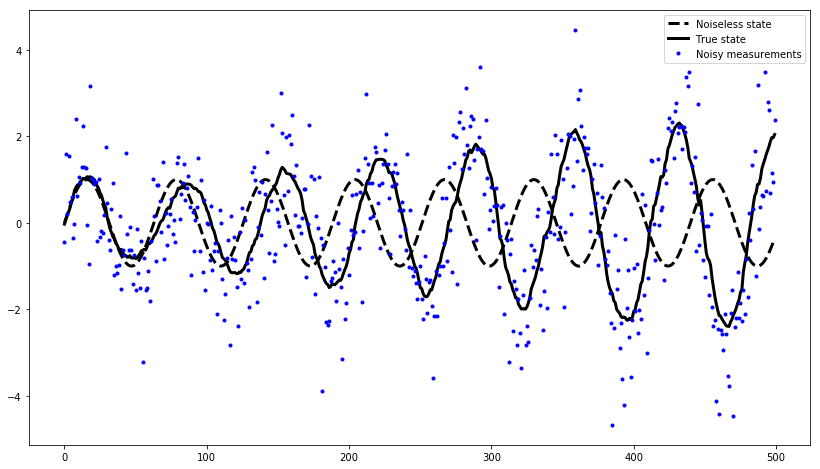

In [4]:
x_noiseless, y_noiseless = model_noiseless(x0, f=f, h=h, n=n_t)
x_true, y_true, y_noisy = model_noisy(x0, f, Q, None, h, R, n=n_t)

plt.figure(figsize=(14, 8))

plt.plot(y_noiseless.T, 'k--',lw=3)
plt.plot(y_true.T, 'k-',lw=3)
plt.plot(y_noisy.T,'b.')

plt.legend(labels=['Noiseless state', 'True state', 'Noisy measurements'])

In [5]:
ekf = ExtendedKalmanFilter(x0, P0, f, Q, Fx, None, h, R, Hx, None)

x_estimate = np.zeros_like(x_true)
P_estimate = np.zeros((n_x, n_x, n_t))
y_estimate = np.zeros_like(y_true)
P_yestimate = np.zeros((n_y, n_y, n_t))

x_estimate[:,0]   = x0.ravel()
y_estimate[:,0]    = feval(h, x0).ravel()
P_estimate[:,:,0]  = P0
P_yestimate[:,:,0] = feval(Hx, x0) @ P0 @ feval(Hx, x0).T + R

for i_ in range(1, n_t):
    ekf.predict()
    ekf.update(y_noisy[:,i_])
    
    x_estimate[:,i_] = ekf.state['expected'].ravel()
    P_estimate[:,:,i_] = ekf.state['err_cov']
    
    y_estimate[:,i_] = feval(h, x_estimate[:,i_].reshape(n_x,1)).ravel()
    H_ = feval(Hx, x_estimate[:,i_].reshape(x0.shape))
    P_yestimate[:,:,i_] = np.atleast_2d(H_ @ P_estimate[:,:,i_] @ H_.T + R)

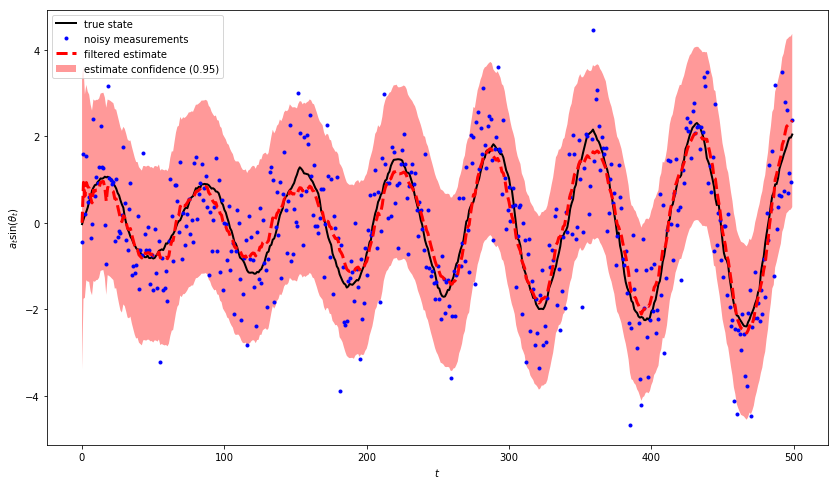

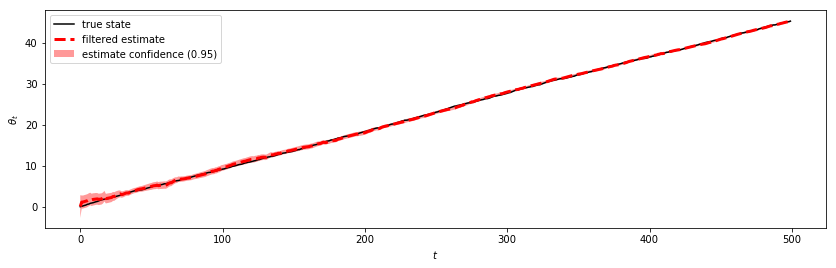

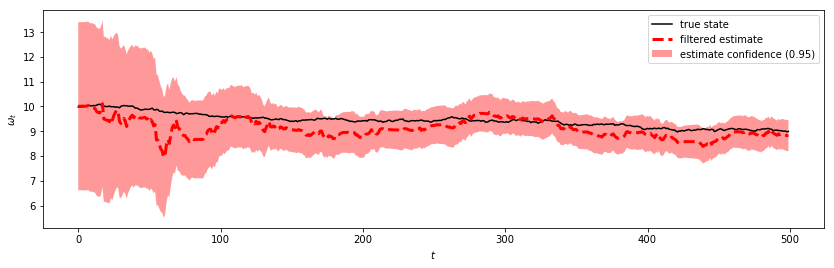

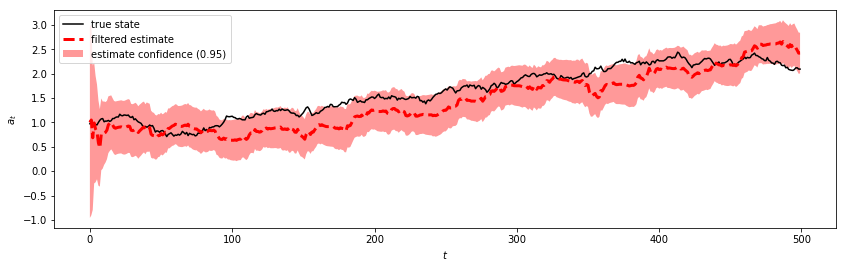

In [6]:
plt.figure(figsize=(14, 8))

plt.plot(y_true.T, 'k-', lw=2)
plt.plot(y_noisy.T, 'b.')

plot_estimate(np.arange(n_t), y_estimate[0,:], P_yestimate[0,0,:])

plt.xlabel('$t$')
plt.ylabel(r'$a_t\sin(\theta_t)$')
plt.legend(labels=['true state','noisy measurements','filtered estimate','estimate confidence (0.95)'])

lbl = [r'$\theta_t$',r'$\omega_t$',r'$a_t$']
for i in range(3):
    plt.figure(figsize=(14,4))
    plt.plot(x_true[i,:].ravel(),'k-')
    
    plot_estimate(np.arange(n_t), x_estimate[i,:], P_estimate[i,i,:])
    plt.xlabel('$t$')
    plt.ylabel(lbl[i])
    plt.legend(labels=['true state','filtered estimate','estimate confidence (0.95)'])

In [7]:
erts = ExtendedKalmanSmoother.from_filter(ekf)
states = erts.smooth()

x_smoothed = np.zeros_like(x_true)
P_smoothed = np.zeros((n_x, n_x, n_t))
y_smoothed = np.zeros_like(y_true)
P_ysmoothed = np.zeros((n_y, n_y, n_t))

for i_ in range(n_t):
    x_smoothed[:,i_] = states[i_]['expected'].ravel()
    P_smoothed[:,:,i_] = states[i_]['err_cov']
    
    y_smoothed[:,i_] = feval(h,x_smoothed[:,i_].reshape(n_x,1)).ravel()
    
    H_ = feval(Hx, x_smoothed[:,i_].reshape(x0.shape))
    P_ysmoothed[:,:,i_] = np.atleast_2d(H_ @ P_smoothed[:,:,i_] @ H_.T + R)

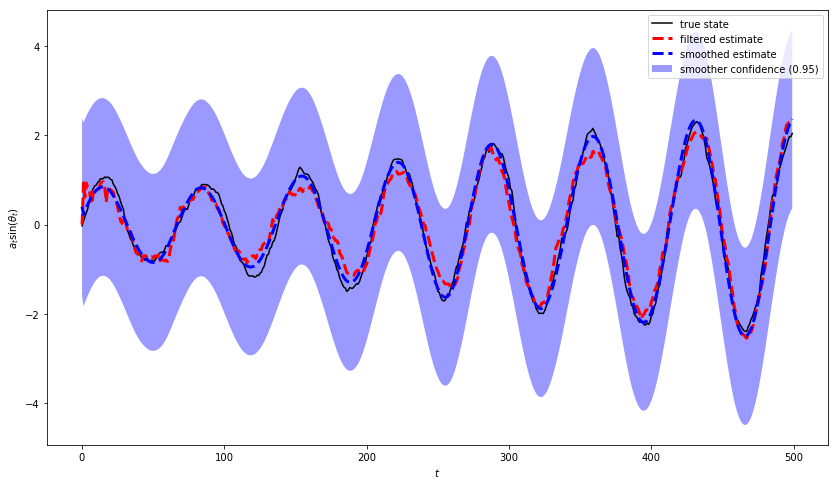

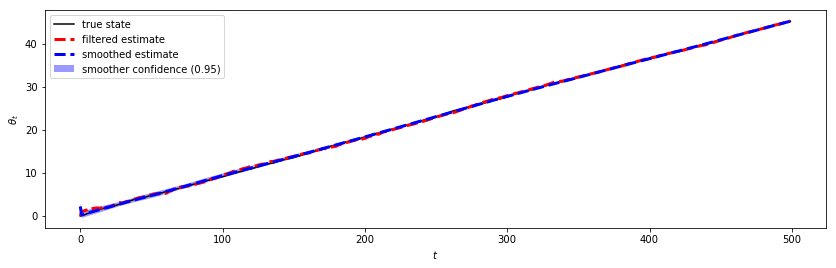

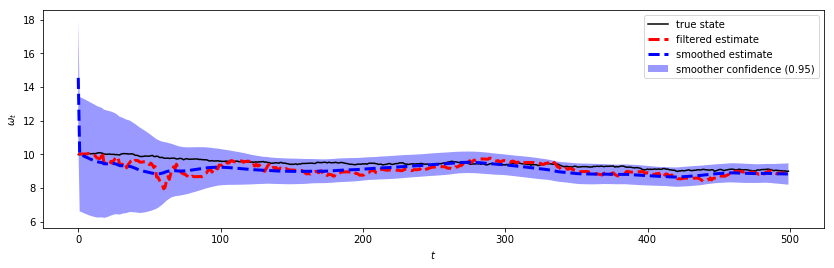

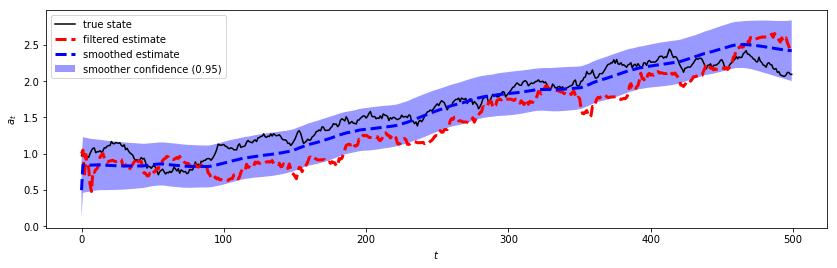

In [8]:
plt.figure(figsize=(14, 8))

plt.plot(y_true.T, 'k-')
plt.plot(y_estimate.T, 'r--', lw=3)
    
plot_estimate(np.arange(n_t), y_smoothed, P_ysmoothed,'b')

plt.xlabel('$t$')
plt.ylabel(r'$a_t\sin(\theta_t)$')
plt.legend(labels=['true state','filtered estimate','smoothed estimate','smoother confidence (0.95)'])

lbl = [r'$\theta_t$',r'$\omega_t$',r'$a_t$']
for i in range(3):
    plt.figure(figsize=(14,4))
    plt.plot(x_true[i,:].ravel(),'k-')
    plt.plot(x_estimate[i,:].ravel(), 'r--',lw=3)
    
    plot_estimate(np.arange(n_t), x_smoothed[i,:], P_smoothed[i,i,:],'b')
    
    plt.xlabel('$t$')
    plt.ylabel(lbl[i])

    plt.legend(labels=['true state','filtered estimate','smoothed estimate','smoother confidence (0.95)'])

In [9]:
# Hessians
Fxx = None

def Hxx(x, p=None):
    """ Hessian matrix """
    H = np.zeros((1, 3, 3))
    H[:,0,0] = -x[2] * np.sin(x[0])
    H[:,0,2] = np.cos(x[0])
    H[:,2,0] = np.cos(x[0])
    return H

print(Hxx(x0).shape)

(1, 3, 3)


In [10]:
ekf2 = SecondOrderExtendedKalmanFilter(x0, P0, f, Q, Fx, None, Fxx, h, R, Hx, None, Hxx)

x_estimate = np.zeros_like(x_true)
P_estimate = np.zeros((n_x, n_x, n_t))
y_estimate = np.zeros_like(y_true)
P_yestimate = np.zeros((n_y, n_y, n_t))

x_estimate[:,0] = x0.ravel()
y_estimate[:,0] = feval(h, x0).ravel()
P_estimate[:,:,0] = P0

P_yestimate[:,:,0] = feval(Hx, x0) @ P0 @ feval(Hx, x0).T + R
for i_ in range(n_y):
    for j_ in range(n_y):
        P_yestimate[i_,j_, 0] += 0.5 * np.trace(np.squeeze(feval(Hxx, x0) @ P0 @ feval(Hxx, x0) @ P0))

for i_ in range(1, n_t):
    ekf2.predict()
    ekf2.update(y_noisy[:,i_])
    
    x_estimate[:,i_] = ekf2.state['expected'].ravel()
    P_estimate[:,:,i_] = ekf2.state['err_cov']
    
    y_estimate[:,i_] = feval(h, x_estimate[:,i_].reshape(n_x,1)).ravel()
    
    P_yestimate[:,:,i_] = H_ @ P_estimate[:,:,i_] @ H_.T + R
    
    G = feval(Hxx, x_estimate[:,i_].reshape(x0.shape))
              
    for j_ in range(n_y):
        for k_ in range(n_y):
              P_yestimate[j_,k_,i_] += 0.5*np.trace(G[j_,:,:] @ P_estimate[:,:,i_] @ np.squeeze(G[k_,:,:] @ P_estimate[:,:,i_]))

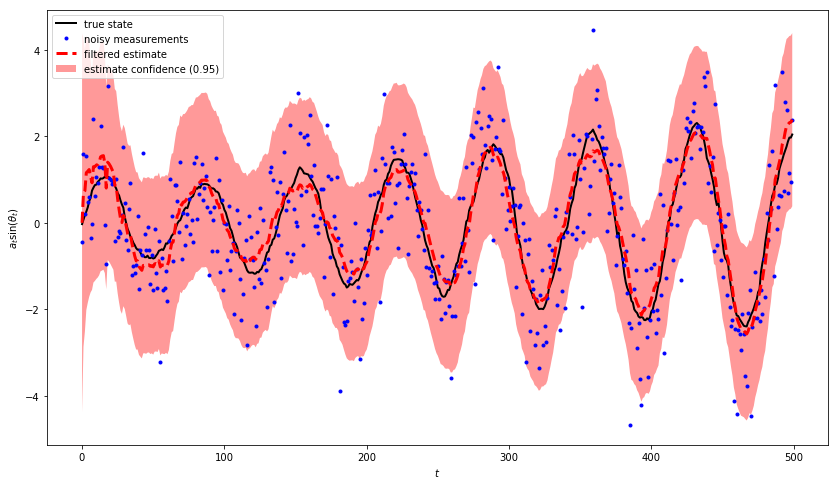

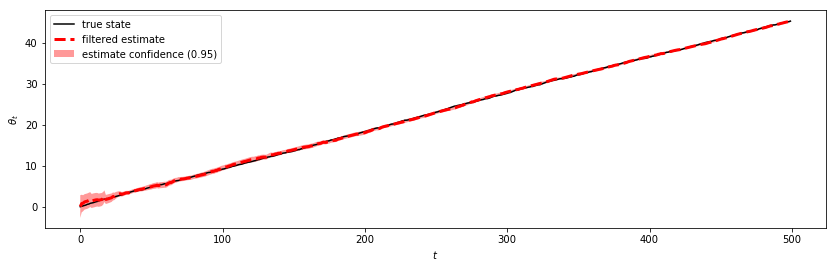

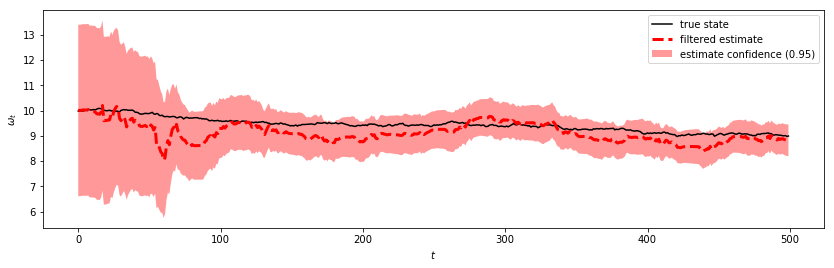

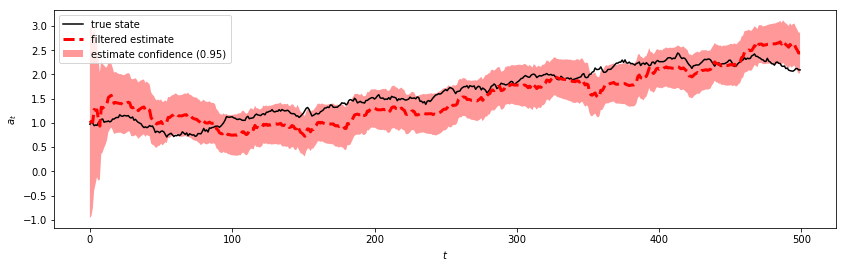

In [11]:
plt.figure(figsize=(14, 8))

plt.plot(y_true.T, 'k-', lw=2)
plt.plot(y_noisy.T, 'b.')

plot_estimate(np.arange(n_t), y_estimate[0,:], P_yestimate[0,0,:])
    
plt.xlabel('$t$')
plt.ylabel(r'$a_t\sin(\theta_t)$')
plt.legend(labels=['true state','noisy measurements','filtered estimate','estimate confidence (0.95)'])


lbl = [r'$\theta_t$',r'$\omega_t$',r'$a_t$']

for i in range(3):
    plt.figure(figsize=(14,4))
    plt.plot(x_true[i,:].ravel(),'k-')
    
    plot_estimate(np.arange(n_t), x_estimate[i,:], P_estimate[i,i,:])
    
    plt.xlabel('$t$')
    plt.ylabel(lbl[i])
    plt.legend(labels=['true state','filtered estimate','estimate confidence (0.95)'])

In [12]:
epr = SecondOrderExtendedKalmanFilter(x0, P0, f, Q, Fx, None, Fxx, h, R, Hx, None, Hxx)

# Ratio of filter to prediction 0.8:0.2 
n_s = int(np.fix(0.8 * n_t))

x_predict = np.zeros((n_x, n_t-n_s))
P_predict = np.zeros((n_x, n_x, n_t-n_s))
y_predict = np.zeros((n_y, n_t-n_s))
P_ypredict = np.zeros((n_y, n_y, n_t-n_s))

for i_ in range(1, n_s):
    epr.predict()
    epr.update(y_noisy[:,i_])
    
for i_ in range(0,n_t-n_s):
    epr.predict()
    x_predict[:,i_]   = epr.state['expected'].ravel()
    P_predict[:,:,i_] = epr.state['err_cov']
    
    y_predict[:,i_]   = feval(h,x_predict[:,i_].reshape(n_x,1)).ravel()
    
    P_ypredict[:,:,i_] = H_ @ P_predict[:,:,i_] @ H_.T + R
    
    G = feval(Hxx, x_predict[:,i_].reshape(x0.shape))
              
    for j_ in range(n_y):
        for k_ in range(n_y):
              P_predict[j_,k_,i_] += 0.5*np.trace(G[j_,:,:] @ P_predict[:,:,i_] @ np.squeeze(G[k_,:,:] @ P_predict[:,:,i_]))


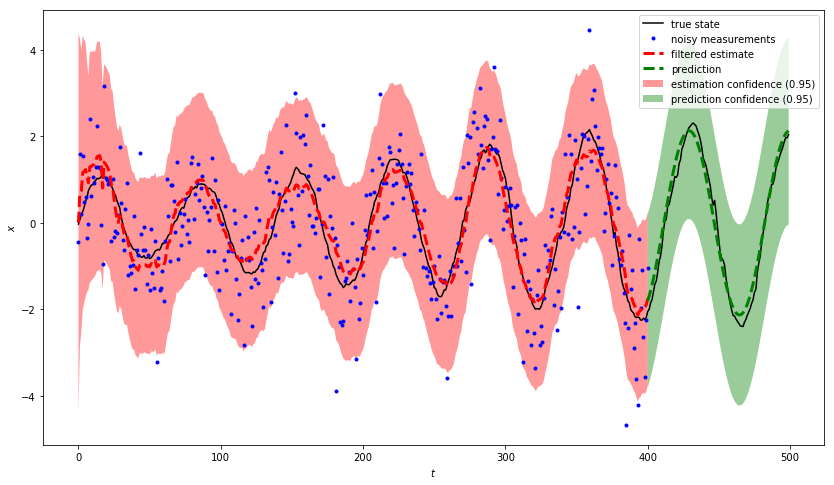

In [13]:
plt.figure(figsize=(14, 8))

plt.plot(y_true.T, 'k-')
plt.plot(y_noisy[:,0:n_s+1].T, 'b.')

# Plot filter estimation (red)
plot_estimate(np.arange(n_s+1), y_estimate[0,0:n_s+1], P_yestimate[0,0,0:n_s+1])
# Plot prediction
plot_estimate(np.arange(n_s,n_t), y_predict, P_ypredict, 'g')

plt.xlabel('$t$')
plt.ylabel('$x$')
plt.legend(labels=['true state', 'noisy measurements', 'filtered estimate','prediction','estimation confidence (0.95)','prediction confidence (0.95)'])